In [1]:
import os
import json
import requests

import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt


In [2]:
#! pip install bokeh

In [3]:
os.makedirs("data", exist_ok=True)
os.makedirs("visualisations", exist_ok=True)

Loading pickled GME stock price dataframe

In [4]:
# Replace this with the path to your pickled file
pickle_file_path = 'scraping\gme_daily_transformed_df.pkl'

# Load the DataFrame from the pickle file
gme_daily_transformed_df = pd.read_pickle(pickle_file_path)

Filtering dataframe to only include dates in the relevant period

In [5]:
# Filtering the DataFrame to include only data from December 2020 to April 2021 and creating a copy
gme_jan_apr2021_df = gme_daily_transformed_df[(gme_daily_transformed_df['Date'] >= '2021-01-01') & (gme_daily_transformed_df['Date'] <= '2021-04-01')].copy()

Reading Reddit data from csv files into dataframe

In [6]:
data1_df = pd.read_csv('./data/reddit_data/Submissions_2021-01_FilteredBySubreddit_GME.csv')
data2_df = pd.read_csv('./data/reddit_data/Submissions_2021-02_FilteredBySubreddit_GME.csv')
data3_df = pd.read_csv('./data/reddit_data/Submissions_2021-03_FilteredBySubreddit_GME.csv')

df_all_reddit_data = pd.concat([data1_df, data2_df, data3_df], axis = 0,
                        ignore_index=True)


In [7]:
df_all_reddit_data.head()

,submission_id,redditor_name,created_at,title,text,subreddit,permalink,attachment,flair,score,num_comments,edited
0,ko124i,[deleted],2021-01-01T00:02:06,"3k - 170k since March (Also, buy LIT!!)",[deleted],wallstreetbets,https://www.reddit.com/r/wallstreetbets/commen...,NaN,"{'link': 'Gain', 'author': None}",{'2021-06-10T13:50:58': 34},{'2021-06-10T13:50:58': 14},False
1,ko12uq,[deleted],2021-01-01T00:03:20,Got out of PLTR calls after learning about IV ...,[deleted],wallstreetbets,https://www.reddit.com/r/wallstreetbets/commen...,{'url': 'https://www.reddit.com/gallery/ko12uq'},"{'link': 'Gain', 'author': None}",{'2021-06-10T13:50:59': 2},{'2021-06-10T13:50:59': 0},False
2,ko13df,[deleted],2021-01-01T00:04:11,Hell of a headline,[deleted],wallstreetbets,https://www.reddit.com/r/wallstreetbets/commen...,{'png': 'https://i.redd.it/620igsuk3m861.png'},"{'link': 'Meme', 'author': None}",{'2021-06-10T13:50:59': 14},{'2021-06-10T13:50:59': 7},False
3,ko13q2,DarkCookie243,2021-01-01T00:04:47,A message from JPow for New Years Eve to all o...,NaN,wallstreetbets,https://www.reddit.com/r/wallstreetbets/commen...,{'jpg': 'https://i.redd.it/rkb331xu3m861.jpg'},"{'link': 'Meme', 'author': None}",{'2021-06-10T13:51:00': 4},{'2021-06-10T13:51:00': 0},False
4,ko145e,stevenconrad,2021-01-01T00:05:29,"GME to 420.69, but only if we make it happen. ...",[removed],wallstreetbets,https://www.reddit.com/r/wallstreetbets/commen...,NaN,"{'link': 'DD', 'author': None}",{'2021-06-10T13:51:00': 9},{'2021-06-10T13:51:00': 4},False


Processing dataframe

In [8]:
# Remove curly brackets from num_comments and score columns
df_all_reddit_data['num_comments'] = df_all_reddit_data['num_comments'].str.replace('[{}]'.format(''.join(['{}'])), '', regex=True)
df_all_reddit_data['score'] = df_all_reddit_data['score'].str.replace('[{}]'.format(''.join(['{}'])), '', regex=True)


# Remove date and time from num_comments and score columns
df_all_reddit_data['num_comments'] = df_all_reddit_data['num_comments'].str.split(':').str[-1].str.strip()
df_all_reddit_data['score'] = df_all_reddit_data['score'].str.split(':').str[-1].str.strip()


# Convert num_comments and score columns to integers
df_all_reddit_data['num_comments'] = df_all_reddit_data['num_comments'].astype(int)
df_all_reddit_data['score'] = df_all_reddit_data['score'].astype(int)


df_all_reddit_data['created_at'] = pd.to_datetime(df_all_reddit_data['created_at'])
# Extract only the date part
df_all_reddit_data['created_at'] = df_all_reddit_data['created_at'].dt.normalize()


In [9]:
df_all_reddit_data.head()


,submission_id,redditor_name,created_at,title,text,subreddit,permalink,attachment,flair,score,num_comments,edited
0,ko124i,[deleted],2021-01-01,"3k - 170k since March (Also, buy LIT!!)",[deleted],wallstreetbets,https://www.reddit.com/r/wallstreetbets/commen...,NaN,"{'link': 'Gain', 'author': None}",34,14,False
1,ko12uq,[deleted],2021-01-01,Got out of PLTR calls after learning about IV ...,[deleted],wallstreetbets,https://www.reddit.com/r/wallstreetbets/commen...,{'url': 'https://www.reddit.com/gallery/ko12uq'},"{'link': 'Gain', 'author': None}",2,0,False
2,ko13df,[deleted],2021-01-01,Hell of a headline,[deleted],wallstreetbets,https://www.reddit.com/r/wallstreetbets/commen...,{'png': 'https://i.redd.it/620igsuk3m861.png'},"{'link': 'Meme', 'author': None}",14,7,False
3,ko13q2,DarkCookie243,2021-01-01,A message from JPow for New Years Eve to all o...,NaN,wallstreetbets,https://www.reddit.com/r/wallstreetbets/commen...,{'jpg': 'https://i.redd.it/rkb331xu3m861.jpg'},"{'link': 'Meme', 'author': None}",4,0,False
4,ko145e,stevenconrad,2021-01-01,"GME to 420.69, but only if we make it happen. ...",[removed],wallstreetbets,https://www.reddit.com/r/wallstreetbets/commen...,NaN,"{'link': 'DD', 'author': None}",9,4,False


Groupby - keep looking into

In [10]:
df_all_reddit_data.rename(columns={'created_at': 'Date'}, inplace=True)
df_grouped = df_all_reddit_data.groupby('Date')

df_grouped = df_all_reddit_data.groupby('Date').size().reset_index(name='Post_Count')

df_comments_count = df_all_reddit_data.groupby('Date')['num_comments'].sum().reset_index(name='Total_Comments')

# Merge 'df_grouped' with 'df_comments_count' on 'Date'
df_grouped = df_grouped.merge(df_comments_count, on='Date', how='left')

df_grouped


# Now, you can perform operations on each group
# For example, you can calculate the sum of 'score' and 'num_comments' for each date
#result = df_grouped[['score', 'num_comments']].sum()

# The result DataFrame will have 'created_at' date as the index and sum of 'score' and 'num_comments' for each date
#print(result)

,Date,Post_Count,Total_Comments
0,2021-01-01,589,45186
1,2021-01-02,625,11609
2,2021-01-03,613,25134
3,2021-01-04,1029,55169
4,2021-01-05,965,65804
...,...,...,...
86,2021-03-28,1178,30131
87,2021-03-29,2065,85797
88,2021-03-30,2105,91976
89,2021-03-31,2147,82231


In [11]:
merged_df = df_grouped.merge(gme_jan_apr2021_df, on='Date', how='outer')
merged_df

,Date,Post_Count,Total_Comments,Open,High,Low,Close,Volume
0,2021-01-01,589,45186,NaN,NaN,NaN,NaN,NaN
1,2021-01-02,625,11609,NaN,NaN,NaN,NaN,NaN
2,2021-01-03,613,25134,NaN,NaN,NaN,NaN,NaN
3,2021-01-04,1029,55169,19.00,19.1000,17.1500,17.25,10022474.0
4,2021-01-05,965,65804,17.35,18.0765,17.2300,17.37,4961457.0
...,...,...,...,...,...,...,...,...
86,2021-03-28,1178,30131,NaN,NaN,NaN,NaN,NaN
87,2021-03-29,2065,85797,180.75,193.9200,173.5100,181.30,10042175.0
88,2021-03-30,2105,91976,187.50,204.3000,182.0000,194.46,17094924.0
89,2021-03-31,2147,82231,197.50,199.4600,187.1102,189.82,8393834.0


In [12]:
cleaned_df = merged_df.dropna()
cleaned_df['Volume'] = cleaned_df['Volume'].astype(int)
# Remove the last row using .iloc
cleaned_df = cleaned_df.iloc[:-1]
cleaned_df

C:\Users\annaj\AppData\Local\Temp\ipykernel_28708\2409377096.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['Volume'] = cleaned_df['Volume'].astype(int)


,Date,Post_Count,Total_Comments,Open,High,Low,Close,Volume
3,2021-01-04,1029,55169,19.00,19.1000,17.1500,17.25,10022474
4,2021-01-05,965,65804,17.35,18.0765,17.2300,17.37,4961457
5,2021-01-06,1225,77419,17.34,18.9800,17.3300,18.36,6056248
6,2021-01-07,1399,68127,18.47,19.4500,18.0200,18.08,6129276
7,2021-01-08,1551,95624,18.18,18.3000,17.0800,17.69,6481960
...,...,...,...,...,...,...,...,...
83,2021-03-25,3493,146707,123.49,187.5000,116.9000,183.75,49926442
84,2021-03-26,2986,148208,197.68,218.9344,163.2600,181.00,37430672
87,2021-03-29,2065,85797,180.75,193.9200,173.5100,181.30,10042175
88,2021-03-30,2105,91976,187.50,204.3000,182.0000,194.46,17094924


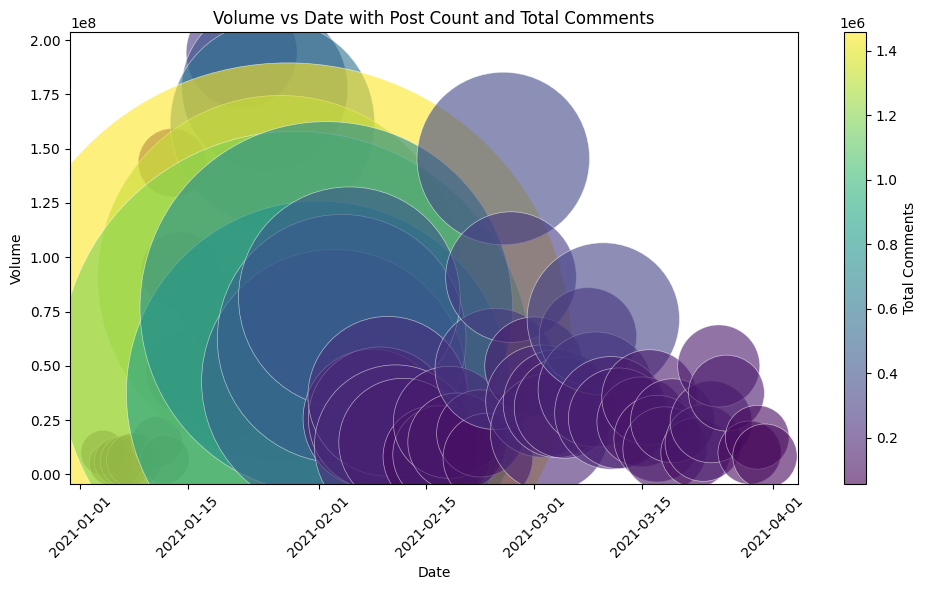

In [13]:
import matplotlib.pyplot as plt

# Creating the plot directly with matplotlib

# Converting 'Date' to datetime for plotting
cleaned_df['Date'] = pd.to_datetime(cleaned_df['Date'])

# Setting the size of the plot
plt.figure(figsize=(10, 6))

# Scatter plot: 'Post_Count' as size, 'Total_Comments' as color
scatter = plt.scatter(cleaned_df['Date'], cleaned_df['Volume'], 
                      s=cleaned_df['Post_Count'],  # size of points
                      c=cleaned_df['Total_Comments'],  # color of points
                      cmap='viridis', alpha=0.6, edgecolors='w', linewidth=0.5)

# Adding the color bar
plt.colorbar(scatter, label='Total Comments')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Volume vs Date with Post Count and Total Comments')

# Rotating the date labels for better visibility
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()


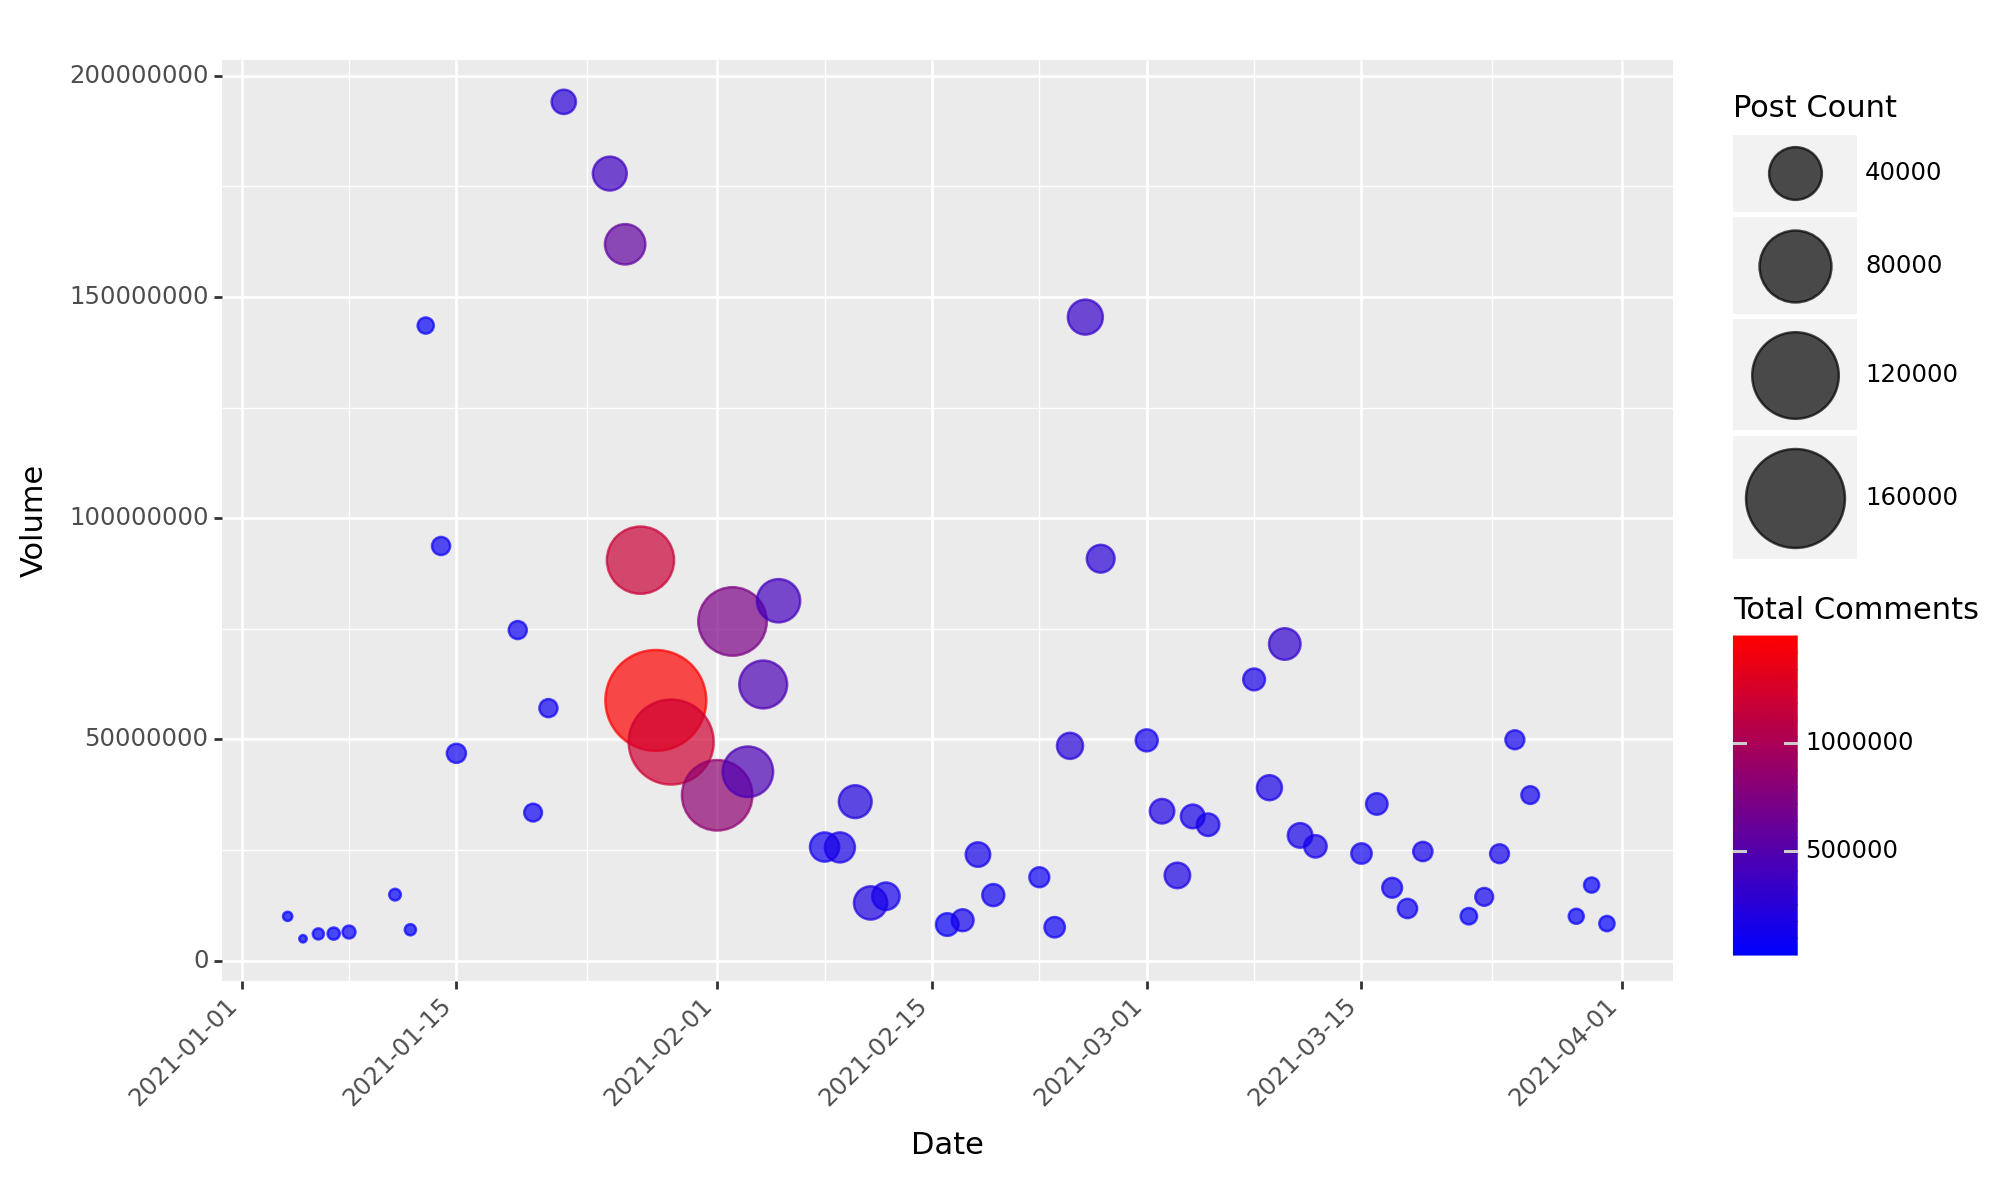

In [14]:
from plotnine import ggplot, aes, geom_point, scale_size, scale_colour_gradient, theme, element_text
from plotnine import labs

plot = (
    ggplot(cleaned_df, aes('Date', 'Volume', size='Post_Count', color='Total_Comments')) +
    geom_point(alpha=0.7) +  # Removed stroke for compatibility
    scale_size(range=(1, 20)) +  # Adjust size range as needed
    scale_colour_gradient(low="blue", high="red") +  # Correct function name
    labs(x='Date', y='Volume', color='Total Comments', size='Post Count') +
    theme(
        axis_text_x=element_text(angle=45, hjust=1),  # Correct usage of element_text
        figure_size=(10, 6)  # Set figure size
    )
)

print(plot)


Volume, Post count and Comment count ** confused about which variables go where

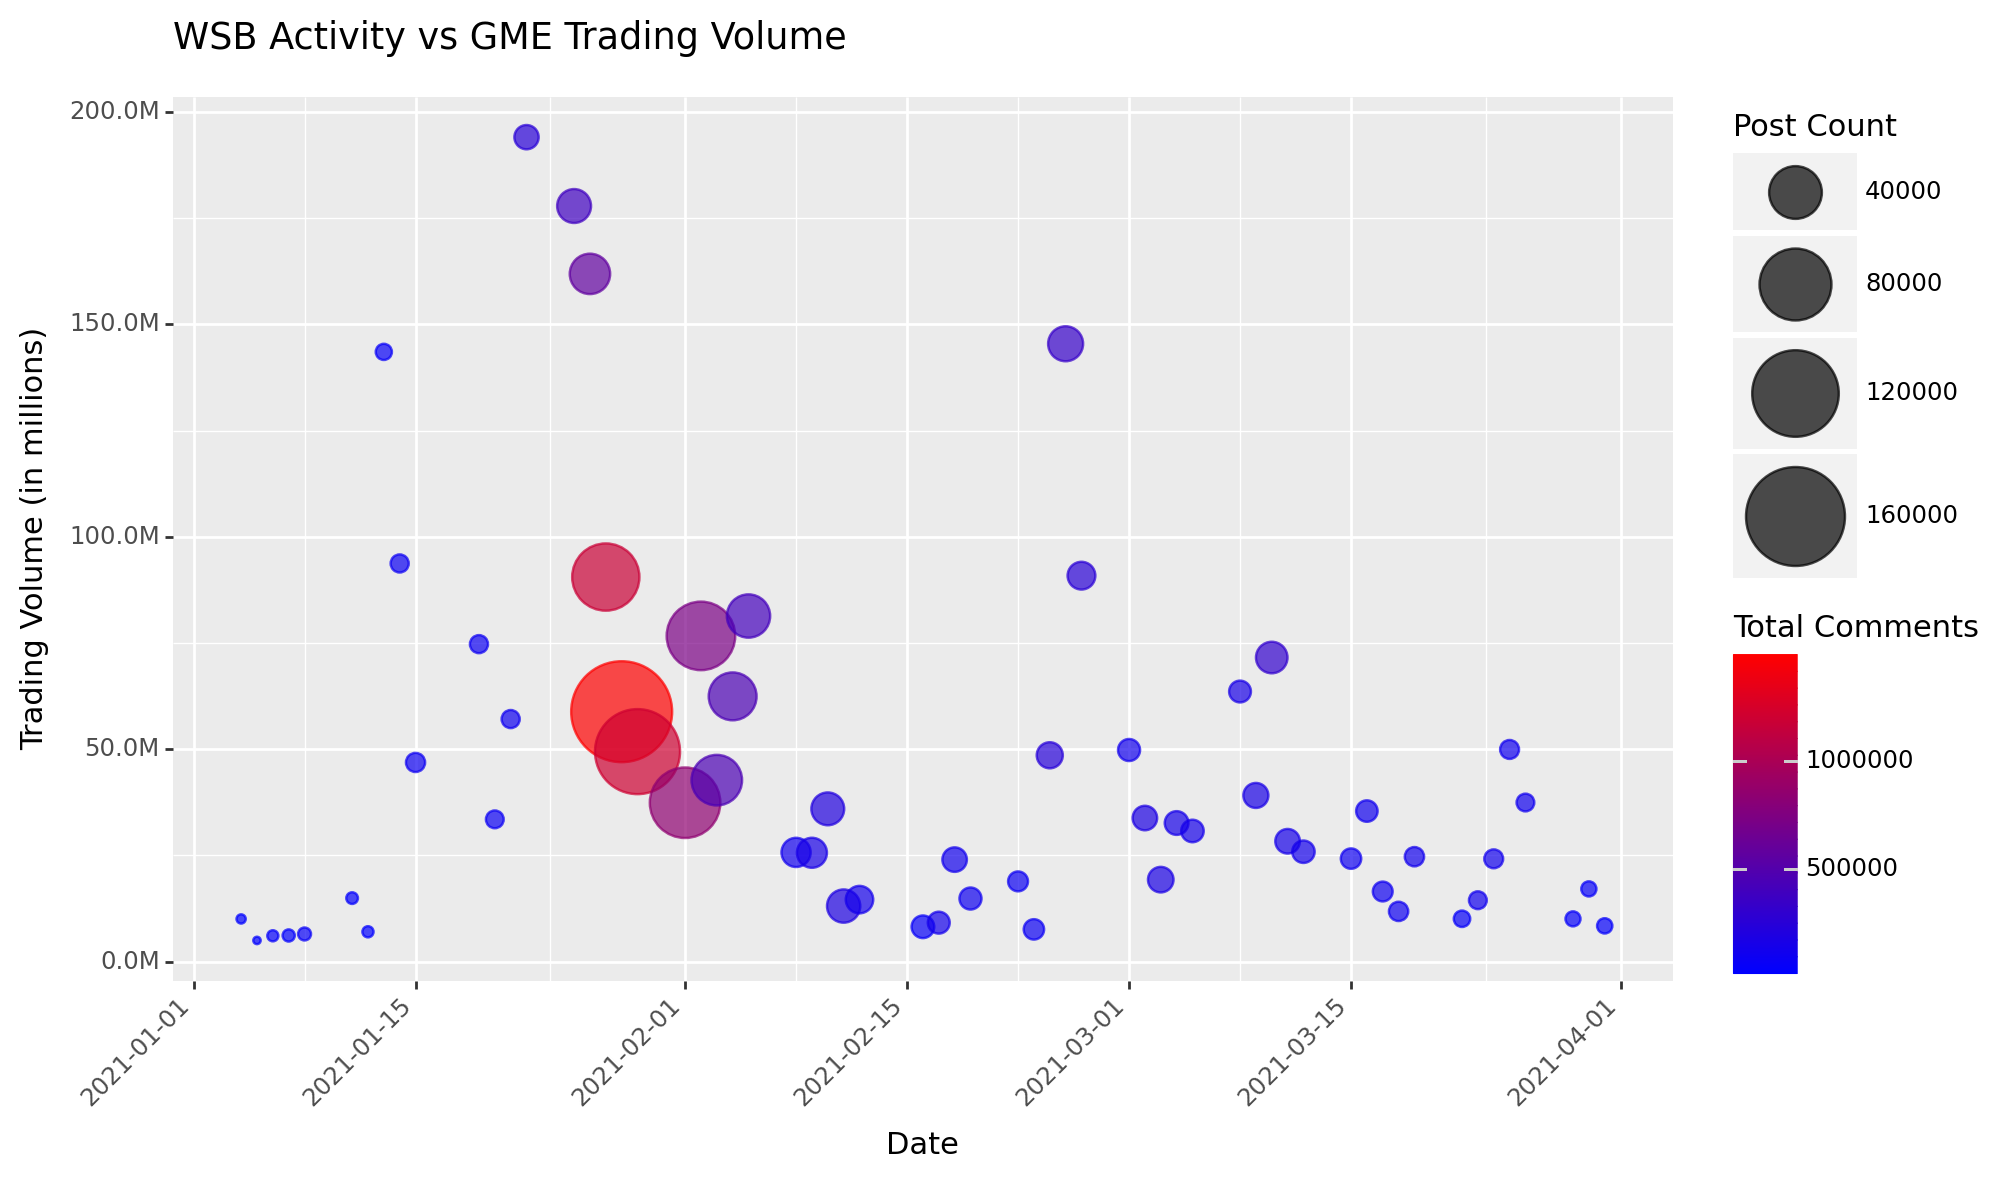

In [15]:
from plotnine import scale_y_continuous, geom_line

plot = (
    ggplot(cleaned_df, aes('Date', 'Volume', size='Post_Count', color='Total_Comments')) +
    geom_point(alpha=0.7, stroke=0.5) +
    #geom_line(aes(y='Close'), color='black', size=1) +  # Adding a line plot for the 'Close' price
    scale_size(range=(1, 20)) +
    scale_colour_gradient(low="blue", high="red") +
    scale_y_continuous(labels=lambda l: ['{:.1f}M'.format(v / 1e6) for v in l]) +  # Format y-axis labels
    labs(
        x='Date',
        y='Trading Volume (in millions)',
        color='Total Comments',
        size='Post Count',
        title='WSB Activity vs GME Trading Volume'
    ) +
    theme(
        axis_text_x=element_text(angle=45, hjust=1),
        figure_size=(10, 6)
    )
)

print(plot)


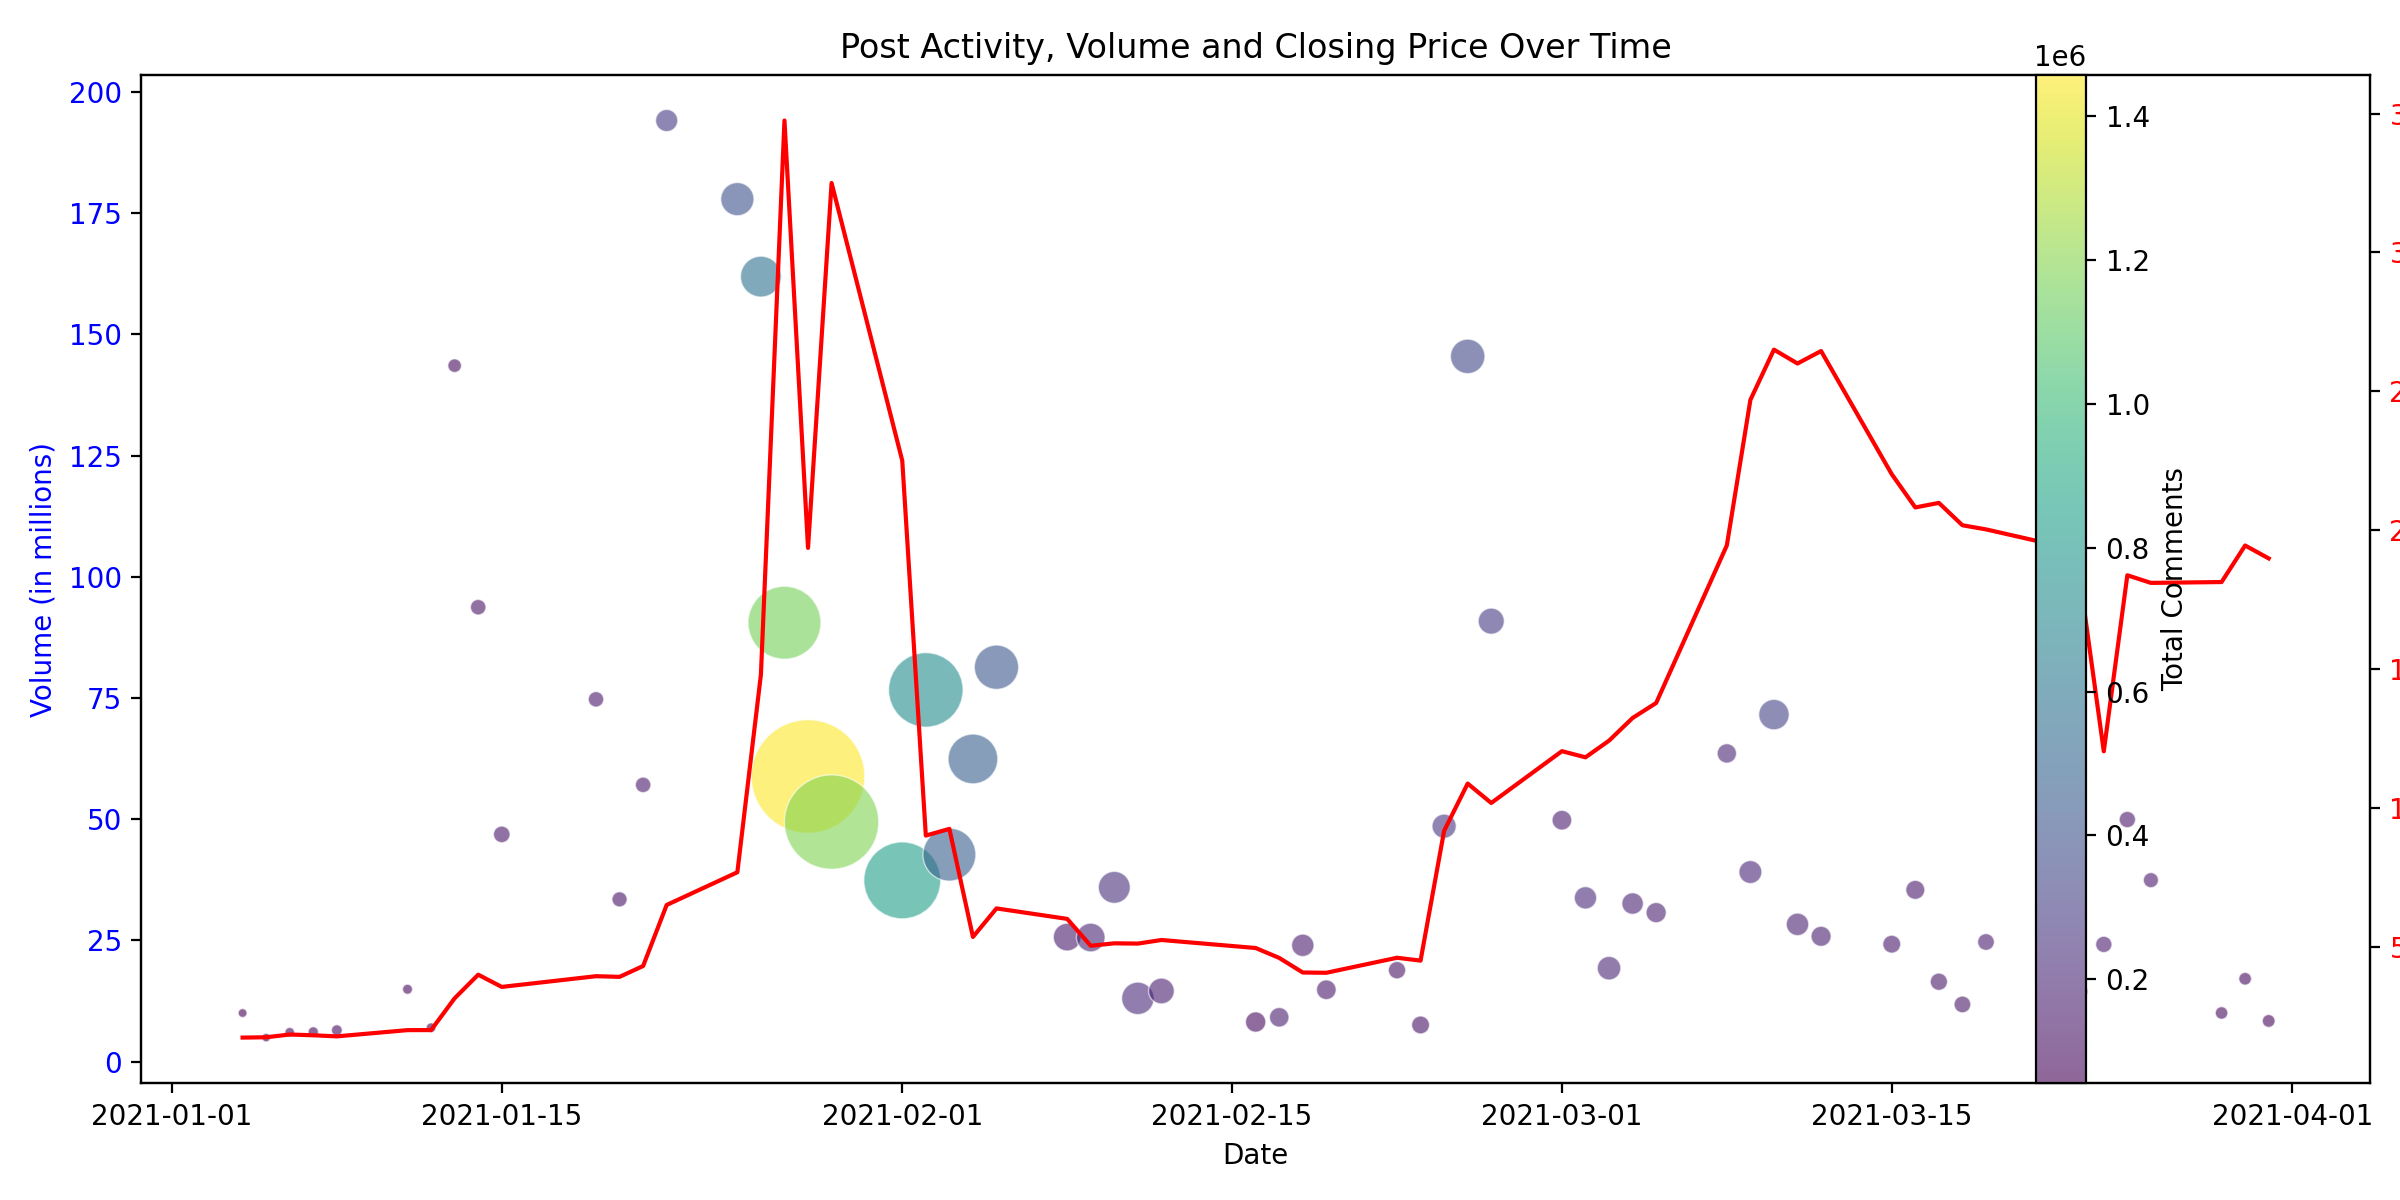

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'cleaned_df' is already loaded and contains the relevant columns

# Convert the 'Date' column to datetime if it isn't already
cleaned_df['Date'] = pd.to_datetime(cleaned_df['Date'])

# Create a new figure and a left axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the Volume as a scatter plot on the left y-axis
scatter = ax1.scatter(cleaned_df['Date'], cleaned_df['Volume']/1e6, 
                      c=cleaned_df['Total_Comments'], 
                      cmap='viridis', alpha=0.6, edgecolors='w', linewidth=0.5, 
                      s=cleaned_df['Post_Count']/100)  # Size scaled down for visibility

# Create the right y-axis with a shared x-axis
ax2 = ax1.twinx()

# Plot the Close price as a line plot on the right y-axis
ax2.plot(cleaned_df['Date'], cleaned_df['Close'], 'r-')

# Set the y-axis label for the left y-axis
ax1.set_ylabel('Volume (in millions)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Set the y-axis label for the right y-axis
ax2.set_ylabel('Close Price', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Set the x-axis label
ax1.set_xlabel('Date')

# Set the title of the plot
plt.title('Post Activity, Volume and Closing Price Over Time')

# Rotate the date labels for better readability
plt.xticks(rotation=45)

# Add a color bar for the scatter plot
cbar = plt.colorbar(scatter, ax=ax1)
cbar.set_label('Total Comments')

# Show plot
plt.tight_layout()
plt.show()


In [17]:
from bokeh.plotting import figure, show
from bokeh.models import LinearAxis, Range1d, ColumnDataSource, LinearColorMapper, ColorBar, NumeralTickFormatter
from bokeh.transform import transform
from bokeh.io import output_notebook
import pandas as pd

# Assuming 'cleaned_df' is a pandas DataFrame with your data

# Convert 'Date' to datetime if it's not already
cleaned_df['Date'] = pd.to_datetime(cleaned_df['Date'])

# Apply a scaling factor to 'Post_Count' to get a suitable size for the circles
scaling_factor = 0.1  # Example scaling factor, adjust as needed
cleaned_df['circle_sizes'] = cleaned_df['Post_Count'] * scaling_factor

# Create a color mapper for 'Total_Comments'
color_mapper = LinearColorMapper(palette="Viridis256", low=cleaned_df['Total_Comments'].min(), high=cleaned_df['Total_Comments'].max())

# Create a data source including the new 'size' column
source = ColumnDataSource(cleaned_df)

# Bokeh uses its own output functions, you can use output_file to save to a file or output_notebook to display inline in a Jupyter notebook
output_notebook()

# Create a new figure
p = figure(width=1000, height=500, x_axis_type='datetime')

# Set the y_range for the Volume axis to end at 250 million
p.y_range = Range1d(start=0, end=300)

# Make sure to use the 'size' column for the size of the circles
#p.circle('Date', 'Volume', size='circle_sizes', source=source, color=transform('Total_Comments', color_mapper), alpha=0.8, legend_label='Volume (in millions)')
# Add circle glyphs to the figure
p.circle(x='Date', y='Volume', size='circle_sizes', source=source, color=transform('Total_Comments', color_mapper), alpha=0.7)
# Add the primary y-axis (left side) for Volume
p.yaxis.axis_label = 'Volume (in millions)'

# Specify the range for the secondary y-axis (right side)
p.extra_y_ranges = {'Close Price': Range1d(start=cleaned_df['Close'].min(), end=cleaned_df['Close'].max())}

# Add the secondary y-axis (right side) for Close Price
p.line('Date', 'Close', source=source, color='red', y_range_name='Close Price', legend_label='Close Price')
p.add_layout(LinearAxis(y_range_name='Close Price', axis_label='Close Price'), 'right')

# Add color bar for 'Total_Comments'
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0,0), title='Total Comments', formatter=NumeralTickFormatter(format="0,0"))
p.add_layout(color_bar, 'right')

# Add legends
p.legend.location = 'top_left'

# Show the result
show(p)


Loading BokehJS ...

In [18]:
# Check the range of volume data to ensure it's within the y-axis range
print(cleaned_df['Volume'].min(), cleaned_df['Volume'].max())



4961457 194084194


In [19]:
cleaned_df['Post_Count'].max()

166996

# This is the plot
### Maybe animate it

In [27]:
from bokeh.plotting import figure, show, output_file, save
from bokeh.models import ColumnDataSource, LinearColorMapper, ColorBar, NumeralTickFormatter, Title
from bokeh.transform import transform
from bokeh.models.tools import HoverTool
from bokeh.models import Range1d  # Import Range1d for secondary y-axis
import pandas as pd

# Ensure your dataframe is sorted by date if it's not already
cleaned_df['Date'] = pd.to_datetime(cleaned_df['Date'])
cleaned_df.sort_values('Date', inplace=True)

# Create a ColumnDataSource from the dataframe
source = ColumnDataSource(cleaned_df)

# Create a color mapper for total comments with a color bar
color_mapper = LinearColorMapper(palette="Viridis256", low=cleaned_df['Total_Comments'].min(), high=cleaned_df['Total_Comments'].max())

# Define a size mapping based on 'Post_Count', here we scale the 'Post_Count' values to a range of 6 to 30
# Adjust this scaling factor to suit the size of your plot or preference
scale_factor = 0.0015  # This is a scaling factor for the size
max_size = 10000
min_size = 5
cleaned_df['size'] = cleaned_df['Post_Count'] * scale_factor
cleaned_df['size'] = cleaned_df['size'].clip(lower=min_size, upper=max_size)

# Update the source with the new size data
source.data['size'] = cleaned_df['size']

# Create a figure object
p = figure(width=1450, height=700, x_axis_type="datetime")

# Create a title and customize its properties
title = Title(text="GameStop Trading Frenzy: A Synchronized Surge in Stock Price, Volume, and Online Buzz", text_font_size="16pt", align="center")

# Add circle glyphs to the figure
p.circle(x='Date', y='Volume', size='size', source=source, color=transform('Total_Comments', color_mapper), alpha=0.7)

# Add a color bar to the right of the plot
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0,0), title='Total Comments', formatter=NumeralTickFormatter(format="0,0"))
p.add_layout(color_bar, 'below')

# Customize the plot
p.yaxis.formatter = NumeralTickFormatter(format="0a")
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Trading Volume (in millions)'

# Specify the range for the secondary y-axis (right side)
p.extra_y_ranges = {'Close Price': Range1d(start=cleaned_df['Close'].min(), end=400)}

# Add the secondary y-axis (right side) for Close Price
p.line('Date', 'Close', source=source, color='red', y_range_name='Close Price', legend_label='Close Price')
p.add_layout(LinearAxis(y_range_name='Close Price', axis_label='Close Price'), 'right')

# Add hover tool
hover = HoverTool(tooltips=[("Date", "@Date{%F}"),
                            ("Volume", "@Volume"),
                            ("Post Count", "@Post_Count"),
                            ("Total Comments", "@Total_Comments"),
                            ("Close Price", "@Close")],
                  formatters={'@Date': 'datetime'})
p.add_tools(hover)

# Set the title
p.title = title

# Show the plot
output_file("interactive_plot.html")
save(p)


'c:\\Users\\annaj\\Desktop\\DS105\\ds105a-project-data-dabblers\\interactive_plot.html'

In [21]:
from bokeh.layouts import column
from bokeh.plotting import figure, show, output_file, save, curdoc
from bokeh.models import ColumnDataSource, LinearColorMapper, ColorBar, NumeralTickFormatter, Title
from bokeh.transform import transform
from bokeh.models import HoverTool
from bokeh.models.widgets import Slider
from bokeh.models.callbacks import CustomJS
from bokeh.models import Range1d
import pandas as pd
from bokeh.plotting import output_file, save


# Ensure your dataframe is sorted by date if it's not already
cleaned_df['Date'] = pd.to_datetime(cleaned_df['Date'])
cleaned_df.sort_values('Date', inplace=True)

# Create a ColumnDataSource from the dataframe
source = ColumnDataSource(cleaned_df)

# Create a color mapper for total comments with a color bar
color_mapper = LinearColorMapper(palette="Viridis256", low=cleaned_df['Total_Comments'].min(), high=cleaned_df['Total_Comments'].max())

# Define a size mapping based on 'Post_Count', here we scale the 'Post_Count' values to a range of 6 to 30
# Adjust this scaling factor to suit the size of your plot or preference
scale_factor = 0.0015  # This is a scaling factor for the size
max_size = 10000
min_size = 5
cleaned_df['size'] = cleaned_df['Post_Count'] * scale_factor
cleaned_df['size'] = cleaned_df['size'].clip(lower=min_size, upper=max_size)

# Update the source with the new size data
source.data['size'] = cleaned_df['size']

# Create a figure object
p = figure(width=1450, height=700, x_axis_type="datetime")

# Create a title and customize its properties
title = Title(text="WSB Activity vs GME Trading Volume", text_font_size="20pt", align="center")

# Add circle glyphs to the figure with initial visible count
initial_visible_count = 10
p.circle(x='Date', y='Volume', size='size', source=source, color=transform('Total_Comments', color_mapper), alpha=0.7, legend_label='Total Comments', muted_alpha=0.2, name='circles', visible=False)
p.legend.click_policy = 'mute'

# Add a color bar to the right of the plot
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0, 0), title='Total Comments', formatter=NumeralTickFormatter(format="0,0"))
p.add_layout(color_bar, 'below')

legend_sizes = [6, 18, 30]  # Example sizes
legend_labels = ['Low', 'Medium', 'High']  # Example labels

# Create a legend by adding invisible circles (visible in the legend only)
for size, label in zip(legend_sizes, legend_labels):
    p.circle(x=[], y=[], size=size, color='grey', alpha=0.7, legend_label=label)

# Customize the plot
p.yaxis.formatter = NumeralTickFormatter(format="0a")
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Trading Volume (in millions)'

# Specify the range for the secondary y-axis (right side)
p.extra_y_ranges = {'Close Price': Range1d(start=cleaned_df['Close'].min(), end=cleaned_df['Close'].max())}

# Add the secondary y-axis (right side) for Close Price
p.line('Date', 'Close', source=source, color='red', y_range_name='Close Price', legend_label='Close Price')
p.add_layout(LinearAxis(y_range_name='Close Price', axis_label='Close Price'), 'right')

# Add hover tool
hover = HoverTool(tooltips=[("Date", "@Date{%F}"),
                            ("Volume", "@Volume"),
                            ("Post Count", "@Post_Count"),
                            ("Total Comments", "@Total_Comments"),
                            ("Close Price", "@Close")],
                  formatters={'@Date': 'datetime'})
p.add_tools(hover)

# Set the title
p.title = title

# Add a slider widget for animation
slider = Slider(start=0, end=len(source.data['Date']) - initial_visible_count, step=1, value=0, title="Animate Circles")
slider.js_on_change("value", CustomJS(args=dict(source=source, slider=slider), code="""
    var start = slider.value;
    var end = start + %d;
    var circles = source.data['Date'].map(function(date, index) {
        return index >= start && index < end;
    });
    source.data['circles'] = circles;
""" % initial_visible_count))

# Create a layout for the plot and slider
layout = column(p, slider)

# To save to an HTML file
output_file("animated_plot.html")
save(layout)

'c:\\Users\\annaj\\Desktop\\DS105\\ds105a-project-data-dabblers\\animated_plot.html'

In [22]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, LinearColorMapper, ColorBar, NumeralTickFormatter, FixedTicker, Legend, LegendItem
from bokeh.transform import transform
from bokeh.models.tools import HoverTool
import pandas as pd

# Assuming 'cleaned_df' is your DataFrame and is already prepared with the 'Date' and 'size' fields

# Create a ColumnDataSource from the dataframe
source = ColumnDataSource(cleaned_df)

# Create a color mapper for total comments with a color bar
color_mapper = LinearColorMapper(palette="Viridis256", low=cleaned_df['Total_Comments'].min(), high=cleaned_df['Total_Comments'].max())

# Define a size mapping based on 'Post_Count', here we scale the 'Post_Count' values to a range of 6 to 30
# Adjust this scaling factor to suit the size of your plot or preference
max_size = 30
min_size = 6
scale_factor = max_size / cleaned_df['Post_Count'].max()  # This is a scaling factor for the size

# Add the scaled sizes to the data source
source.data['size'] = cleaned_df['Post_Count'] * scale_factor
source.data['size'] = source.data['size'].clip(lower=min_size, upper=max_size)

# Create a figure object
p = figure(width=800, height=400, x_axis_type="datetime", title="WSB Activity vs GME Trading Volume")

# Add circle glyphs to the figure
p.circle(x='Date', y='Volume', size='size', source=source, color=transform('Total_Comments', color_mapper), alpha=0.7)

# Add legend for sizes (manually create legend items)
legend_items = [
    LegendItem(label="Low", renderers=[p.circle(x=[], y=[], size=min_size, color="grey", alpha=0.7)]),
    LegendItem(label="Medium", renderers=[p.circle(x=[], y=[], size=(min_size+max_size)/2, color="grey", alpha=0.7)]),
    LegendItem(label="High", renderers=[p.circle(x=[], y=[], size=max_size, color="grey", alpha=0.7)])
]

# Create and add the custom legend
size_legend = Legend(items=legend_items, location="top_left", spacing=0, title="Post Count")
p.add_layout(size_legend, 'above')

# Add a color bar to the right of the plot
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, ticker=FixedTicker(ticks=[color_mapper.low, color_mapper.high]), formatter=NumeralTickFormatter(format="0,0"))
p.add_layout(color_bar, 'right')

# Customize the plot
p.yaxis.formatter = NumeralTickFormatter(format="0.0a")
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Trading Volume (in millions)'

# Add hover tool
hover = HoverTool(tooltips=[("Date", "@Date{%F}"),
                            ("Volume", "@Volume{0.0a}"),
                            ("Post Count", "@Post_Count"),
                            ("Total Comments", "@Total_Comments{0,0}")],
                  formatters={'@Date': 'datetime'})
p.add_tools(hover)

# Show the plot
show(p)


In [23]:
from bokeh.plotting import figure, show
from bokeh.io import curdoc
from bokeh.layouts import row, column
from bokeh.models import Slider, ColumnDataSource
from bokeh.transform import factor_cmap
import pandas as pd

# Load and preprocess data
# df_stocks = pd.read_csv('stocks.csv') # Load stock data
# df_reddit = pd.read_csv('reddit.csv') # Load reddit data

# Create a ColumnDataSource from your data
source_stocks = ColumnDataSource(cleaned_df)
source_reddit = ColumnDataSource(df_all_reddit_data)

# Create plots
p1 = figure(title="Stock Close Prices", x_axis_type='datetime')
p1.line('Date', 'Close', source=source_stocks, line_width=2)

p2 = figure(title="Reddit Post Scores", x_axis_type='datetime')
p2.vbar(x='created_at', top='score', source=source_reddit, width=0.9)

# Create widgets
slider = Slider(start=0, end=10, value=1, step=1, title="Slider")

# Define callback for widgets
def update_data(attrname, old, new):
    # Update the plot based on the slider
    scale = slider.value
    new_data = dict()
    new_data['Close'] = cleaned_df['Close'] * scale
    source_stocks.data = new_data

slider.on_change('value', update_data)

# Arrange plots and widgets in a layout
layout = column(row(slider), row(p1, p2))

# Add the layout to the current document
curdoc().add_root(layout)

# Run the server
# To run this, you would save it as a .py file and then run `bokeh serve --show mydashboard.py`


In [24]:
import pandas as pd
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, DatetimeTickFormatter, HoverTool
from bokeh.models import LabelSet, CustomJS, Div, Circle, TapTool
from bokeh.layouts import layout
from bokeh.io import curdoc
import datetime

In [25]:
# If 'Date' is not a column, this will reset the index and make 'Date' a column
if 'Date' not in gme_jan_apr2021_df.columns:
    gme_jan_apr2021_df.reset_index(inplace=True)

# Ensure 'Date' is in datetime format
gme_jan_apr2021_df['Date'] = pd.to_datetime(gme_jan_apr2021_df['Date'])

# Create the figure
p = figure(title="GME Daily Closing Prices (Jan 2021 - Apr 2021)",
           x_axis_label='Date', y_axis_label='Close Price ($)',
           x_axis_type='datetime', width=800, height=400)

# Add a line renderer with legend and line thickness
p.line('Date', 'Close', source=source, legend_label="Close Price", line_width=2)

# Dates for the red circles (buttons)
button_dates = [pd.Timestamp('2021-01-11'), 
                pd.Timestamp('2021-01-13'), 
                pd.Timestamp('2021-01-26'),
                pd.Timestamp('2021-01-27'), 
                pd.Timestamp('2021-01-28'), 
                pd.Timestamp('2021-01-29'),
                pd.Timestamp('2021-02-01'),
                pd.Timestamp('2021-02-25')]


# Extract close prices for the specified button dates
button_close_prices = [
    gme_jan_apr2021_df.loc[gme_jan_apr2021_df['Date'] == date, 'Close'].iloc[0]
    for date in button_dates
]

# Special information for each button date
special_infos = ["New leaders appointed", 
                 "Stock surges more than 50%",
                 "Elon Musk tweet",
                 "Citron Capital and Melvin Capital close their short positions",
                 "Robinhood restricts trading of GME",
                 "SEC intervenes and Trading platforms lift restrictions on GME",
                 "Decline in value",
                 "Temporary resurgence"]

# Create a separate ColumnDataSource for the red circles
button_source = ColumnDataSource({
    'x': button_dates,
    'y': button_close_prices,
    'info': special_infos
})

# Add the red circles to the plot
circle_renderer = p.circle('x', 'y', size=15, color='red', source=button_source)

# Create a hover tool for the main plot line
line_hover = HoverTool(
    tooltips=[
        ('Date', '@Date{%F}'),
        ('Close', '$@Close{0,0.00}')
    ],
    formatters={'@Date': 'datetime'},
    mode='vline'
)

# Create a hover tool for the red circles that displays special information
circle_hover = HoverTool(
    tooltips=[
        ('Info', '@info')
    ],
    # Only apply this hover tool to the red circles
    renderers=[circle_renderer]
)


p.add_tools(line_hover)

# Add the hover tool to the plot for the red circles
p.add_tools(circle_hover)

# Updated format for the datetime axis
p.xaxis.formatter = DatetimeTickFormatter(
    days="%d %b %Y",
    months="%b %Y",
    years="%Y"
)

output_file("interactive_plot2.html")
save(p)

RuntimeError: Models must be owned by only a single document, Selection(id='p1305', ...) is already in a doc

In [ ]:
gme_jan_apr2021_df.head()

,Date,Open,High,Low,Close,Volume
0,2021-01-04,19.00,19.1000,17.15,17.25,10022474
1,2021-01-05,17.35,18.0765,17.23,17.37,4961457
2,2021-01-06,17.34,18.9800,17.33,18.36,6056248
3,2021-01-07,18.47,19.4500,18.02,18.08,6129276
4,2021-01-08,18.18,18.3000,17.08,17.69,6481960


In [ ]:
# Set 'Date' as the DataFrame index
#gme_jan_apr2021_df.set_index('Date', inplace=True)

if 'Date' not in gme_jan_apr2021_df.columns:
    gme_jan_apr2021_df = gme_jan_apr2021_df.reset_index()
# Create a ColumnDataSource for Bokeh plotting
source = ColumnDataSource(data=gme_jan_apr2021_df)

# Create the figure
p = figure(title="GME Daily Closing Prices (Jan - Apr 2021)", 
           x_axis_label='Date', y_axis_label='Close Price ($)', 
           x_axis_type='datetime', width=800, height=400)

# Add a line renderer with legend and line thickness
p.line(x='Date', y='Close', source=source, legend_label="Close Price", line_width=2)

# Updated format for the datetime axis
p.xaxis.formatter = DatetimeTickFormatter(
    days="%d %b %Y",
    months="%b %Y",
    years="%Y"
)

# Example of adding labels using LabelSet
#labels = LabelSet(x='Date', y='Close', text='Close', level='glyph',
#                  x_offset=5, y_offset=5, source=source)
#p.add_layout(labels)

# Add a hover tool to the plot
hover = HoverTool(
    tooltips=[
        ('Date', '@Date{%F}'),  # Use the { } to format the date
        ('Close', '$@Close{0,0.00}')  # Use { } to format the close price
    ],
    formatters={
        '@Date': 'datetime',  # Use 'datetime' formatter for '@Date' field
    },
    mode='vline'  # Display a tooltip whenever the cursor is vertically in line with a glyph
)



p.add_tools(hover)

# Updated format for the datetime axis
p.xaxis.formatter = DatetimeTickFormatter(
    days="%d %b %Y",
    months="%b %Y",
    years="%Y"
)
# Add a circle glyph as a "button" on a specific date, e.g., January 15
# Define specific dates for the special hover information
button_dates = [pd.Timestamp('2021-01-15'), pd.Timestamp('2021-01-27')]
special_infos = ["Special info for January 15", "More special info for January 27"]

#button_source = ColumnDataSource({'x': [button_date], 'y': [gme_jan_apr2021_df[gme_jan_apr2021_df['Date'] == button_date]['Close'].iloc[0]]})
#circle = Circle(x='x', y='y', size=15, fill_color='red')
#p.add_glyph(button_source, circle)

# Create a separate ColumnDataSource for the button circle
button_source = ColumnDataSource({
    'x': [button_dates],
    'y': [gme_jan_apr2021_df.loc[gme_jan_apr2021_df['Date'] == button_dates, 'Close'].iloc[0]],
    'info': [special_infos]
})

# Add a circle glyph as a "button" on a specific date, e.g., January 15
circle_glyph = p.circle(x='x', y='y', size=20, fill_color='red', source=button_source)

# Define custom hover tooltips
custom_hover = HoverTool(
    renderers=[circle_glyph],
    tooltips=[
        ('Info', '@info')
    ]
)

# Add the custom hover tool to the plot
p.add_tools(custom_hover)

# Add the TapTool to the plot

# Show the plot with the callback

show(p)
output_notebook()


ValueError: ('Lengths must match to compare', (62,), (2,))